Курсовой проект

# Загружаем основные библиотеки и файлы в проект

In [ ]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

In [ ]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

In [ ]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATASET_TRAIN_PATH = '/content/drive/My Drive/работа с кодами/курсовая/train.csv'
DATASET_TEST_PATH = '/content/drive/My Drive/работа с кодами/курсовая/test_kaggle.csv'

In [ ]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
train_df = pd.read_csv(DATASET_TRAIN_PATH, sep = ',')
#train_df = reduce_mem_usage(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [ ]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [ ]:
test_df = pd.read_csv(DATASET_TEST_PATH, sep = ',')
#test_df = reduce_mem_usage(test_df)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [ ]:
test_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [ ]:
print(train_df.shape[0])
print(test_df.shape[0])

10000
5000


In [ ]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

# EDA

In [ ]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [ ]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  object 
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Rooms - избавимся от выбросов

In [ ]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [ ]:
train_df['Rooms'].loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6)]

2004    10.0
2194     0.0
2728    10.0
3780     0.0
5894     0.0
6088    19.0
6401     0.0
7644     0.0
7929     0.0
8794     6.0
9767     0.0
9869     0.0
Name: Rooms, dtype: float64

In [ ]:
train_df.loc[(train_df['Rooms'] == 0)] = 1
train_df.loc[(train_df['Rooms'] >= 6)] = train_df['Rooms'].median()

In [ ]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

Заполним пустые значение

In [ ]:
train_df.isna()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
9996,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
9997,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
9998,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2110
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4790
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

LifeSquare

In [ ]:
train_df['LifeSquare'].describe()

count    7890.000000
mean       37.113014
std        86.203572
min         0.370619
25%        22.736747
50%        32.753788
75%        45.105670
max      7480.592129
Name: LifeSquare, dtype: float64

In [ ]:
train_df['LifeSquare_nan'] = 0
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,...,B,52,10311,6,NaN,1,9,B,119367.455796,0
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,...,B,2,629,1,NaN,0,0,A,199715.148807,0
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,...,B,20,4386,14,NaN,1,5,B,165953.912580,0
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,...,B,47,8004,3,125.0,3,5,B,171842.411855,0


In [ ]:
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare_nan'] = 1
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,1
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,1
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,...,B,52,10311,6,NaN,1,9,B,119367.455796,0
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,...,B,2,629,1,NaN,0,0,A,199715.148807,0
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,...,B,20,4386,14,NaN,1,5,B,165953.912580,0
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,...,B,47,8004,3,125.0,3,5,B,171842.411855,0


In [ ]:
median = train_df['LifeSquare'].median()
train_df['LifeSquare'].fillna(median).isna().sum()


0

In [ ]:
train_df['LifeSquare'].isna().sum()

2110

In [ ]:
train_df['LifeSquare'].describe()

count    7890.000000
mean       37.113014
std        86.203572
min         0.370619
25%        22.736747
50%        32.753788
75%        45.105670
max      7480.592129
Name: LifeSquare, dtype: float64

In [ ]:

train_df['LifeSquare'] = train_df['LifeSquare'].fillna(median)
train_df['LifeSquare'].isna().sum()

0

Работа над выбросами в LifeSquare

In [ ]:
train_df.drop(columns =['LifeSquare_nan'], axis = 1, inplace = True)

In [ ]:
total_ls_max_value = np.quantile(train_df['LifeSquare'], q=0.985)
total_ls_max_value

83.79494342337867

In [ ]:
total_ls_min_value = np.quantile(train_df['LifeSquare'], q=0.015)
total_ls_min_value

4.525386236062076

In [ ]:
condition = (train_df['LifeSquare'] > total_ls_max_value) | (train_df['LifeSquare'] < total_ls_min_value)
train_df[condition]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
64,3992,1,3.0,87.200625,87.730225,0.0,21,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,300180.365669
119,5112,6,2.0,63.591740,0.795539,10.0,17,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,174741.998061
142,5402,27,4.0,98.649404,100.855911,1.0,3,1.0,2019,0.072158,B,B,2,629,1,NaN,0,0,A,294689.614794
179,8974,54,2.0,90.144106,91.796522,1.0,10,9.0,2017,0.006076,B,B,30,5285,0,645.0,6,6,B,502813.772665
212,1182,27,1.0,38.936986,3.064320,0.0,18,19.0,2017,0.211401,B,B,9,1892,0,NaN,0,1,B,93560.789553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9938,2913,34,4.0,94.888593,2.637095,1.0,4,1.0,2018,0.069753,B,B,53,13670,4,NaN,1,11,B,346949.506507
9960,16258,48,3.0,96.056784,98.152802,1.0,15,1.0,2017,0.041125,B,B,46,9515,5,NaN,1,10,B,524365.550705
9965,6441,52,3.0,85.796885,85.305246,0.0,15,17.0,1977,0.371149,B,B,34,7065,1,750.0,2,5,B,204462.983720
9982,10268,27,1.0,36.112393,1.855415,1.0,9,16.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,94881.691800


Если жилая площадь больше общей:

In [ ]:
condition_2 = (train_df['Square'] - (train_df['LifeSquare']) < 0)
train_df[condition_2]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
33,847,74,2.0,73.314975,74.131261,1.0,7,6.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,254005.381863
64,3992,1,3.0,87.200625,87.730225,0.0,21,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,300180.365669
77,11771,45,1.0,38.467276,39.624493,1.0,11,9.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,247440.530601
100,13343,74,2.0,79.937665,82.931595,1.0,8,21.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,226808.747168
111,13875,20,1.0,28.438794,32.514021,6.0,6,10.0,2014,0.019509,B,B,37,7687,11,176.0,5,5,B,199248.114376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,16258,48,3.0,96.056784,98.152802,1.0,15,1.0,2017,0.041125,B,B,46,9515,5,NaN,1,10,B,524365.550705
9962,14175,14,1.0,42.029175,44.682167,10.0,4,4.0,2018,0.238617,B,B,26,3889,6,705.0,3,6,B,87556.385617
9979,2201,6,1.0,40.043234,41.984322,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,134888.083598
9987,11665,1,2.0,62.690057,64.602939,10.0,19,22.0,2018,0.007122,B,B,1,264,0,NaN,0,1,B,203908.192698


In [ ]:
train_df.loc[condition_2, 'LifeSquare'] = train_df['LifeSquare'] + (train_df['Square'] - train_df['LifeSquare'])

Square:

In [ ]:
train_df['Square'].describe()

count    10000.000000
mean        56.229944
std         21.057763
min          1.000000
25%         41.751942
50%         52.482304
75%         65.889256
max        641.065193
Name: Square, dtype: float64

In [ ]:
train_df['Square'].value_counts()

1.000000      8
2.000000      4
115.027311    1
76.603972     1
34.589294     1
             ..
54.573861     1
63.952771     1
39.010427     1
66.681968     1
35.815476     1
Name: Square, Length: 9990, dtype: int64

In [ ]:
total_s_min_value = np.quantile(train_df['Square'], q=0.025)
total_s_min_value

31.960690861386603

In [ ]:
condition = train_df['Square'] < total_s_min_value
train_df[condition]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
63,11630,58,1.0,30.961868,15.168644,6.0,3,12.0,1973,0.310199,B,B,11,2748,1,NaN,0,0,B,117941.286753
92,2357,32,1.0,31.828480,15.222565,5.0,5,5.0,1972,0.135650,B,B,46,7960,6,350.0,3,11,B,170343.755036
108,8871,91,1.0,31.691657,20.108517,5.0,1,5.0,1965,0.000995,B,B,42,7651,1,NaN,1,5,B,140029.719549
111,13875,20,1.0,28.438794,28.438794,6.0,6,10.0,2014,0.019509,B,B,37,7687,11,176.0,5,5,B,199248.114376
130,8800,23,1.0,29.706031,29.706031,0.0,5,12.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,60502.583500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9853,872,27,1.0,31.796664,30.229385,10.0,8,22.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,86163.846520
9869,1,1,1.0,1.000000,1.000000,1.0,1,1.0,1,1.000000,1,1,1,1,1,1.0,1,1,1,1.000000
9915,8998,20,1.0,30.082090,12.125029,7.0,9,9.0,1976,0.019509,B,B,37,7687,11,176.0,5,5,B,186537.391208
9990,10635,21,1.0,18.983962,11.419796,2.0,1,5.0,1967,0.194489,B,B,47,8004,3,125.0,3,5,B,112411.221700


In [ ]:
train_df.loc[condition, 'Square'] = train_df['Square'].median()

Минимально допустимое значение

In [ ]:
train_df.loc[train_df['LifeSquare'] < total_ls_min_value]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
119,5112,6,2.0,63.591740,0.795539,10.0,17,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,174741.998061
161,6782,45,1.0,52.482304,2.954309,1.0,3,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,438005.182323
212,1182,27,1.0,38.936986,3.064320,0.0,18,19.0,2017,0.211401,B,B,9,1892,0,NaN,0,1,B,93560.789553
227,3746,62,1.0,46.722042,1.944446,1.0,11,12.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,133721.121715
258,4280,34,2.0,61.334968,4.091945,1.0,26,1.0,2014,0.069753,B,B,53,13670,4,NaN,1,11,B,286564.441972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9462,10079,59,1.0,48.232741,3.288779,1.0,15,17.0,2017,0.019509,B,B,37,7687,11,176.0,5,5,B,207086.637307
9767,1,1,1.0,52.482304,1.000000,1.0,1,1.0,1,1.000000,1,1,1,1,1,1.0,1,1,1,1.000000
9869,1,1,1.0,52.482304,1.000000,1.0,1,1.0,1,1.000000,1,1,1,1,1,1.0,1,1,1,1.000000
9938,2913,34,4.0,94.888593,2.637095,1.0,4,1.0,2018,0.069753,B,B,53,13670,4,NaN,1,11,B,346949.506507


In [ ]:
train_df.loc[train_df['LifeSquare'] < total_ls_min_value, 'LifeSquare'] = train_df[train_df['LifeSquare'] < total_ls_min_value]*10

In [ ]:
train_df.loc[train_df['LifeSquare'] < total_ls_min_value, 'LifeSquare'] = train_df[train_df['LifeSquare'] < total_ls_min_value]*10

In [ ]:
train_df.loc[condition_2, 'LifeSquare'] = train_df['LifeSquare'] + (train_df['Square'] - train_df['LifeSquare'])

In [ ]:
train_df.loc[train_df['LifeSquare'] > 120]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
286,2737,27,3.0,123.430072,123.430072,123.0,5,10.0,2015,0.017647,B,B,2,469,0,NaN,0,0,B,234194.837047
349,6006,62,3.0,121.844004,121.844004,1.0,3,3.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,193847.642016
730,14181,62,3.0,156.636577,153.685835,1.0,1,3.0,2005,0.072158,B,B,2,629,1,NaN,0,0,A,502523.573863
1614,3267,58,3.0,138.980817,138.004600,43.0,2,2.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,169528.896664
1776,16568,27,4.0,200.334539,200.334539,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,NaN,1,4,B,528560.506016
1906,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666
3121,98,54,3.0,120.890731,120.890731,1.0,7,1.0,2015,0.006076,B,B,30,5285,0,645.0,6,6,B,621002.912679
3204,5621,23,3.0,163.495333,161.504222,12.0,5,3.0,1977,0.014073,B,B,2,475,0,NaN,0,0,B,207007.956663
3955,7616,48,4.0,123.846928,123.846928,1.0,7,1.0,2015,0.041125,B,B,46,9515,5,NaN,1,10,B,595128.195352
5283,11055,151,1.0,174.649522,174.649522,15.0,10,12.0,1958,0.236108,B,B,16,3893,27,NaN,3,10,B,232766.187698


KitchenSquare

In [ ]:
train_df['KitchenSquare'].describe()

count    10000.000000
mean         6.270700
std         28.560889
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [ ]:
train_df['KitchenSquare'].value_counts()

1.0       2468
8.0       1306
5.0       1169
10.0      1073
6.0       1037
9.0        842
0.0        690
7.0        608
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
2.0          8
18.0         6
22.0         3
51.0         2
32.0         2
30.0         2
43.0         2
41.0         2
112.0        2
25.0         2
37.0         2
58.0         2
75.0         1
36.0         1
73.0         1
63.0         1
27.0         1
21.0         1
1970.0       1
54.0         1
53.0         1
60.0         1
26.0         1
66.0         1
39.0         1
29.0         1
78.0         1
31.0         1
84.0         1
48.0         1
96.0         1
42.0         1
40.0         1
23.0         1
72.0         1
35.0         1
62.0         1
123.0        1
2014.0       1
Name: KitchenSquare, dtype: int64

In [ ]:
total_ks_max_value = np.quantile(train_df['KitchenSquare'], q=0.995)
total_ks_max_value

20.0

In [ ]:
total_ks_min_value = np.quantile(train_df['KitchenSquare'], q=0.025)
total_ks_min_value

0.0

In [ ]:
condition = train_df['KitchenSquare'] == 0
train_df[condition]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
24,4717,27,1.0,44.203947,32.753788,0.0,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.559958
38,7679,23,2.0,55.521797,32.753788,0.0,3,4.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,93217.752924
64,3992,1,3.0,87.200625,87.200625,0.0,21,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,300180.365669
88,4439,121,2.0,59.840016,32.753788,0.0,22,1.0,1977,0.212515,B,B,19,3293,16,628.0,3,7,B,305673.936207
94,12339,23,1.0,47.485585,32.753788,0.0,5,3.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,126602.673982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9945,3983,6,2.0,63.056315,32.753788,0.0,15,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,178837.821147
9950,5383,48,3.0,98.994909,32.753788,0.0,3,0.0,1977,0.041125,B,B,46,9515,5,NaN,1,10,B,418817.004446
9965,6441,52,3.0,85.796885,85.305246,0.0,15,17.0,1977,0.371149,B,B,34,7065,1,750.0,2,5,B,204462.983720
9991,11173,6,2.0,62.648779,32.753788,0.0,6,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,182625.548872


In [ ]:
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

In [ ]:
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [ ]:
condition = train_df['KitchenSquare'] > total_ks_max_value
train_df[condition]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
277,13559,79,1.0,96.838013,49.140960,22.0,19,24.0,2016,0.050756,B,B,24,5469,1,145.0,0,1,B,348962.861294
286,2737,27,3.0,123.430072,123.430072,123.0,5,10.0,2015,0.017647,B,B,2,469,0,NaN,0,0,B,234194.837047
456,10546,62,1.0,46.013187,43.417043,43.0,4,17.0,2019,0.072158,B,B,2,629,1,NaN,0,0,A,113909.099428
511,8685,62,5.0,124.933289,81.122369,30.0,5,3.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A,271919.866048
682,16593,52,2.0,64.859242,32.753788,62.0,15,17.0,1977,0.371149,B,B,34,7065,1,750.0,2,5,B,185993.474671
755,15781,10,1.0,35.813564,19.953992,35.0,6,14.0,1971,0.282798,B,B,33,8667,2,NaN,0,6,B,164306.314182
1614,3267,58,3.0,138.980817,138.004600,43.0,2,2.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,169528.896664
1728,16395,2,3.0,79.722243,44.731219,72.0,12,16.0,1987,0.130618,B,B,39,10418,9,900.0,1,9,B,370148.625285
1776,16568,27,4.0,200.334539,200.334539,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,NaN,1,4,B,528560.506016
1906,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666


In [ ]:
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

HouseFloor:

In [ ]:
train_df['HouseFloor'].describe()

count    10000.000000
mean        12.602300
std          6.779346
min          0.000000
25%          9.000000
50%         13.000000
75%         17.000000
max        117.000000
Name: HouseFloor, dtype: float64

In [ ]:
train_df['HouseFloor'].value_counts()

17.0     2330
9.0      1388
12.0     1074
5.0      1031
14.0      625
16.0      575
1.0       505
25.0      374
22.0      342
0.0       265
24.0      176
8.0       141
10.0      135
4.0       134
3.0       125
15.0      122
19.0      108
20.0      105
18.0       89
7.0        59
6.0        58
2.0        51
23.0       40
21.0       33
11.0       28
13.0       27
30.0       21
40.0        7
27.0        6
32.0        4
37.0        4
28.0        3
99.0        2
39.0        2
48.0        2
47.0        1
38.0        1
36.0        1
29.0        1
44.0        1
31.0        1
117.0       1
45.0        1
26.0        1
Name: HouseFloor, dtype: int64

In [ ]:
total_hf_max_value = np.quantile(train_df['HouseFloor'], q=0.975)
total_hf_max_value

25.0

In [ ]:
total_hf_min_value = np.quantile(train_df['HouseFloor'], q=0.025)
total_hf_min_value

0.0

In [ ]:
condition = (train_df['HouseFloor'] > total_hf_max_value) | (train_df['HouseFloor'] <= total_hf_min_value)
train_df[condition]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
24,4717,27,1.0,44.203947,32.753788,6.0,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.559958
152,12947,53,2.0,56.023342,32.753788,6.0,14,0.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B,247074.564832
159,13146,74,1.0,46.449711,32.753788,6.0,6,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,168705.450148
186,12174,62,1.0,44.954880,32.753788,6.0,8,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,133773.301722
229,15661,45,3.0,81.094922,32.753788,6.0,15,0.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,442472.456032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9889,629,27,1.0,42.936724,32.753788,6.0,2,0.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,129674.841139
9931,15686,1,1.0,47.402412,32.753788,6.0,14,0.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,174740.301224
9940,4711,6,1.0,41.224118,32.753788,6.0,8,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,125612.639104
9950,5383,48,3.0,98.994909,32.753788,6.0,3,0.0,1977,0.041125,B,B,46,9515,5,NaN,1,10,B,418817.004446


In [ ]:
train_df.loc[condition, 'HouseFloor'] = train_df['Floor']

In [ ]:
train_df['Floor'].describe()

count    10000.000000
mean         8.518000
std          5.242177
min          1.000000
25%          4.000000
50%          7.000000
75%         12.000000
max         42.000000
Name: Floor, dtype: float64

In [ ]:
train_df['Floor'].value_counts()

4     947
5     875
3     871
6     802
7     758
8     643
9     603
2     591
10    553
11    457
12    438
13    397
14    362
16    289
15    287
17    255
1     242
18    185
19    121
20     68
21     59
24     53
22     53
25     34
23     25
26     18
27      5
28      3
32      2
31      1
33      1
42      1
37      1
Name: Floor, dtype: int64

Цена:

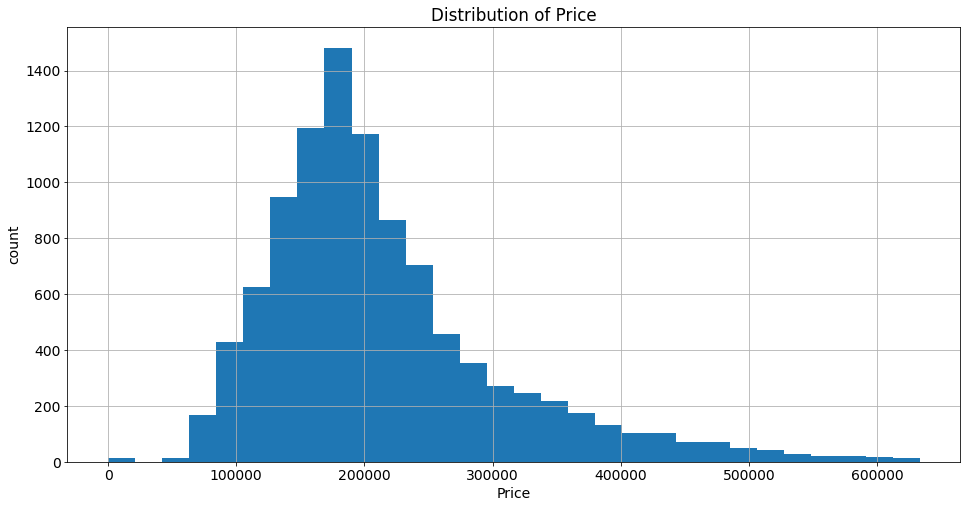

In [ ]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins = 30)
plt.ylabel('count')
plt.xlabel('Price')

plt.title('Distribution of Price')
plt.show()

In [ ]:
train_df['Price'].describe()

count     10000.000000
mean     213898.748172
std       93132.380216
min           1.000000
25%      153681.234400
50%      192113.654461
75%      249094.379680
max      633233.466570
Name: Price, dtype: float64

In [ ]:
total_p_max_value = np.quantile(train_df['Price'], q=0.975)
total_p_max_value

466741.91314522066

In [ ]:
total_p_min_value = np.quantile(train_df['Price'], q=0.025)
total_p_min_value

86829.2100470092

In [ ]:
condition = (train_df['Price'] > total_p_max_value) | (train_df['Price'] < total_p_min_value)
train_df[condition]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
10,535,2,3.0,74.199049,44.735889,10.0,5,14.0,2008,0.035145,B,B,42,9292,3,2620.0,0,3,B,512797.373401
14,191,36,3.0,81.994790,43.688798,10.0,2,22.0,2008,0.087619,B,B,8,1497,5,NaN,1,0,B,481360.360728
30,5931,23,1.0,43.033398,32.753788,3.0,3,4.0,1977,0.014073,B,B,2,475,0,NaN,0,0,B,72659.971575
32,3876,100,4.0,104.769022,79.316650,8.0,4,8.0,1960,0.200147,B,B,23,3975,8,770.0,2,0,B,600903.828562
51,12774,157,2.0,62.747509,28.196813,8.0,5,10.0,1956,0.000000,B,B,30,7538,87,4702.0,5,5,B,555661.943969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9869,1,1,1.0,52.482304,10.000000,3.0,1,1.0,1,1.000000,1,1,1,1,1,1.0,1,1,1,1.000000
9901,671,23,2.0,55.869625,54.177713,10.0,3,17.0,2015,0.005767,B,B,1,388,0,NaN,0,0,B,63900.205590
9937,6149,53,4.0,109.905861,94.268671,20.0,12,24.0,2018,0.049637,B,B,34,7759,0,229.0,1,3,B,492943.252891
9960,16258,48,3.0,96.056784,96.056784,3.0,15,1.0,2017,0.041125,B,B,46,9515,5,NaN,1,10,B,524365.550705


In [ ]:
train_df.loc[condition, 'Price'] = train_df['Price'].median()

Healthcare_1:

In [ ]:
train_df['Healthcare_1'].describe()

count    5210.000000
mean     1140.562380
std      1022.045772
min         0.000000
25%       350.000000
50%       900.000000
75%      1548.000000
max      4849.000000
Name: Healthcare_1, dtype: float64

In [ ]:
train_df['Healthcare_1'].isna()

0        True
1       False
2       False
3        True
4        True
        ...  
9995     True
9996     True
9997     True
9998    False
9999     True
Name: Healthcare_1, Length: 10000, dtype: bool

In [ ]:
median = train_df['Healthcare_1'].median()
train_df['Healthcare_1'].fillna(median).isna().sum()

0

In [ ]:
train_df['Healthcare_1'] = train_df['Healthcare_1'].fillna(median)

HouseYear:

In [ ]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

In [ ]:
train_df['HouseYear'].head()

0    2014
1    1966
2    1988
3    1977
4    1972
Name: HouseYear, dtype: int64

In [ ]:
train_df['HouseYear'].describe()

count    10000.000000
mean      1982.483200
std         71.097283
min          1.000000
25%       1974.000000
50%       1977.000000
75%       2001.000000
max       2020.000000
Name: HouseYear, dtype: float64

In [ ]:
train_df['HouseYear'].value_counts()

1977    2648
2017     308
2016     304
2015     298
2014     209
        ... 
1947       1
1914       1
1928       1
1910       1
1916       1
Name: HouseYear, Length: 97, dtype: int64

In [ ]:
import random
from datetime import datetime

In [ ]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

# Построение новых признаков, отбор признаков

In [ ]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,32.753788,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,900.0,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,32.753788,3.0,10,22.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,900.0,0,6,B,343995.102962


DUMMIES

In [ ]:
binary_to_number = {'A' : 0, 'B' : 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_number)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_number)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_number)

DISRICTS:

In [ ]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                  .rename(columns = {'index' : 'DistrictId', 'DistrictId' : 'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,846
1,1,651
2,23,565
3,6,510
4,9,293


In [ ]:
train_df = train_df.merge(district_size, on = 'DistrictId', how = 'left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize
0,11809,27,3.0,115.027311,32.753788,10.0,4,10.0,2014,0.075424,...,1.0,11,3097,0,900.0,0,0,1.0,305018.871089,846
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1.0,30,6207,1,1183.0,1,0,1.0,177734.553407,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1.0,33,5261,0,240.0,3,1,1.0,282078.720850,651
3,2352,1,1.0,40.409907,32.753788,3.0,10,22.0,1977,0.007122,...,1.0,1,264,0,900.0,0,1,1.0,168106.007630,651
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,1.0,33,8667,2,900.0,0,6,1.0,343995.102962,89


In [ ]:
(train_df['DistrictSize'] > 100).value_counts()

True     5060
False    4940
Name: DistrictSize, dtype: int64

In [ ]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(str)

In [ ]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index = False).agg({'Price' : 'median'})\
                            .rename(columns = {'Price' : 'MedPriceByDistrict'})
            
med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,1,1.0,192113.654461
1,2.0,2.0,192113.654461
2,0,1.0,147258.736617
3,0,2.0,176210.812334
4,0,3.0,289528.364995


In [ ]:
train_df = train_df.merge(med_price_by_district, on = ['DistrictId','Rooms'], how = 'left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027311,32.753788,10.0,4,10.0,2014,0.075424,...,3097,0,900.0,0,0,1.0,305018.871089,846,True,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,6207,1,1183.0,1,0,1.0,177734.553407,78,False,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,5261,0,240.0,3,1,1.0,282078.720850,651,True,244005.272380
3,2352,1,1.0,40.409907,32.753788,3.0,10,22.0,1977,0.007122,...,264,0,900.0,0,1,1.0,168106.007630,651,True,147248.590963
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,8667,2,900.0,0,6,1.0,343995.102962,89,False,201584.441255


In [ ]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5) , 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X
  

def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels= False)

    X['floor_cat'].fillna(-1, inplace = True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941 , 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[X['HouseYear'] > 2010 , 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
  bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
  X['year_cat'] = pd.cut(X['HouseYear'], bins= bins, labels=False)

  X['year_cat'].fillna(-1, inplace= True)
  return X

In [ ]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels= False)

0       1
1       2
2       0
3       3
4       4
       ..
9995    0
9996    3
9997    0
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

In [ ]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins)

0         (3, 5]
1         (5, 9]
2         (0, 3]
3        (9, 15]
4       (15, 42]
          ...   
9995      (0, 3]
9996     (9, 15]
9997      (0, 3]
9998      (0, 3]
9999      (5, 9]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[int64, right]): [(0, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 42]]

In [ ]:
bins = [0, 1941, 1945, 1980, 2000, 2010, train_df['HouseYear'].max()]
pd.cut(train_df['HouseYear'], bins= bins, labels=False)

0       5
1       2
2       3
3       2
4       2
       ..
9995    3
9996    2
9997    2
9998    2
9999    2
Name: HouseYear, Length: 10000, dtype: int64

In [ ]:
bins = [0, 1941, 1945, 1980, 2000, 2010, train_df['HouseYear'].max()]
pd.cut(train_df['HouseYear'], bins= bins)

0       (2010, 2020]
1       (1945, 1980]
2       (1980, 2000]
3       (1945, 1980]
4       (1945, 1980]
            ...     
9995    (1980, 2000]
9996    (1945, 1980]
9997    (1945, 1980]
9998    (1945, 1980]
9999    (1945, 1980]
Name: HouseYear, Length: 10000, dtype: category
Categories (6, interval[int64, right]): [(0, 1941] < (1941, 1945] < (1945, 1980] < (1980, 2000] <
                                         (2000, 2010] < (2010, 2020]]

In [ ]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,115.027311,32.753788,10.0,4,10.0,2014,0.075424,...,900.0,0,0,1.0,305018.871089,846,True,213530.788443,6,2
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1183.0,1,0,1.0,177734.553407,78,False,146032.829834,3,3
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,240.0,3,1,1.0,282078.720850,651,True,244005.272380,4,1
3,2352,1,1.0,40.409907,32.753788,3.0,10,22.0,1977,0.007122,...,900.0,0,1,1.0,168106.007630,651,True,147248.590963,3,4
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,900.0,0,6,1.0,343995.102962,89,False,201584.441255,3,5


In [ ]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index = False).agg({'Price':'median'})\
                                .rename(columns = {'Price' : 'MedPriceByFloorYear'})

med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,192113.654461
1,1,2,278911.258283
2,1,3,305066.130929
3,1,4,233553.063413
4,2,1,251209.364597


In [ ]:
train_df = train_df.merge(med_price_by_floor_year, on = ['year_cat', 'floor_cat'], how = 'left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,32.753788,10.0,4,10.0,2014,0.075424,...,0,0,1.0,305018.871089,846,True,213530.788443,6,2,179822.607158
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,0,1.0,177734.553407,78,False,146032.829834,3,3,190419.239316
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,3,1,1.0,282078.720850,651,True,244005.272380,4,1,201895.819112
3,2352,1,1.0,40.409907,32.753788,3.0,10,22.0,1977,0.007122,...,0,1,1.0,168106.007630,651,True,147248.590963,3,4,186200.286534
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,6,1.0,343995.102962,89,False,201584.441255,3,5,181281.815896


# Отбор признаков

In [ ]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

In [ ]:
feature_names = ['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',]

new_feature_names = ['DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'year_cat',
 'floor_cat',
 'MedPriceByFloorYear']

target_name = ['Price']

In [ ]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.house_year_min = None
        self.floor_min = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.floor_min = df['Floor'].min()
            self.house_year_max = df['HouseYear'].max()
            self.house_year_min = df['HouseYear'].min()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [self.floor_min, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True)
        return X
     
    def year_to_cat(self, X):
        bins = [self.house_year_min, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

# Разбиение на train, test

In [ ]:
train_df = pd.read_csv(DATASET_TRAIN_PATH)
test_df = pd.read_csv(DATASET_TEST_PATH)

X = train_df.drop(columns = target_name)
y = train_df[target_name]

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.33, shuffle = True, random_state = 42)

In [ ]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 22), (3300, 22), (5000, 22))

In [ ]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 29), (3300, 29), (5000, 29))

In [ ]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [ ]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

# Построение модели

In [ ]:
rf_model = RandomForestRegressor(random_state=42, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', random_state=42)

Train R2:	0.966
Test R2:	0.665


ValueError: ignored

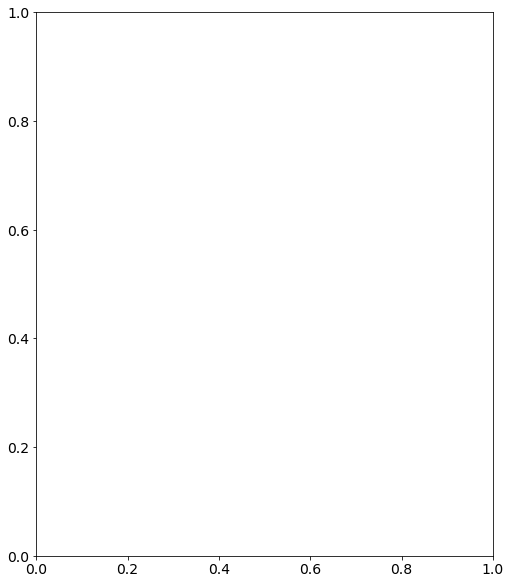

In [ ]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)